<a href="https://colab.research.google.com/github/justprophet/Synthetic-Image-Creation-and-Text-Detection/blob/master/AffineTransformations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Downloading Libraries

In [0]:
#!pip install six numpy scipy Pillow matplotlib scikit-image opencv-python imageio Shapely
#!pip install imgaug

#2. Importing Libraries

In [0]:
#Importing Importand Libraries
import numpy as np
import imgaug as ia
import imgaug.augmenters as iaa


In [0]:
import cv2
import glob
#import numpy as np
from google.colab import drive
drive.mount('/content/gdrive')



Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


#3. Storing Data in Glob

In [0]:
X_data = []
files = glob.glob ("gdrive/My Drive/Practicum/Practicum/Data/bedroompngs/*.png")
for myFile in files:
    #print(myFile)
    image = cv2.imread (myFile)
    X_data.append (image)

print('X_data shape:', np.array(X_data).shape)

X_data shape: (4228,)


#4. Declaring Variables

In [0]:
images = X_data
# Sometimes(0.5, ...) applies the given augmenter in 50% of all cases,
# e.g. Sometimes(0.5, GaussianBlur(0.3)) would blur roughly every second image.
sometimes = lambda aug: iaa.Sometimes(0.5, aug)

#5. Affine Transformations

Affine Transformations 1

In [0]:
# Define our sequence of augmentation steps that will be applied to every image
# All augmenters with per_channel=0.5 will sample one value _per image_
# in 50% of all cases. In all other cases they will sample new values
# _per channel_.
seq = iaa.Sequential(
    [
        # apply the following augmenters to most images
        #iaa.Fliplr(0.5), # horizontally flip 50% of all images
        #iaa.Flipud(0.2), # vertically flip 20% of all images
        # crop images by -5% to 10% of their height/width
        sometimes(iaa.CropAndPad(
            percent=(-0.05, 0.1),
            pad_mode=ia.ALL,
            pad_cval=(0, 255)
        )),
        sometimes(iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # scale images to 80-120% of their size, individually per axis
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, # translate by -20 to +20 percent (per axis)
            rotate=(-45, 45), # rotate by -45 to +45 degrees
            #shear=(-16, 16), # shear by -16 to +16 degrees
            order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
            cval=(0, 255), # if mode is constant, use a cval between 0 and 255
            mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
        )),
        # execute 0 to 5 of the following (less important) augmenters per image
        # don't execute all of them, as that would often be way too strong
        iaa.SomeOf((0, 5),
            [
                sometimes(iaa.Superpixels(p_replace=(0, 1.0), n_segments=(20, 200))), # convert images into their superpixel representation
                iaa.OneOf([
                    iaa.GaussianBlur((0, 3.0)), # blur images with a sigma between 0 and 3.0
                    iaa.AverageBlur(k=(2, 7)), # blur image using local means with kernel sizes between 2 and 7
                    iaa.MedianBlur(k=(3, 11)), # blur image using local medians with kernel sizes between 2 and 7
                ]),
                iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)), # sharpen images
                iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)), # emboss images
                # search either for all edges or for directed edges,
                # blend the result with the original image using a blobby mask
                iaa.SimplexNoiseAlpha(iaa.OneOf([
                    iaa.EdgeDetect(alpha=(0.5, 1.0)),
                    iaa.DirectedEdgeDetect(alpha=(0.5, 1.0), direction=(0.0, 1.0)),
                ])),
                iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5), # add gaussian noise to images
                iaa.OneOf([
                    iaa.Dropout((0.01, 0.1), per_channel=0.5), # randomly remove up to 10% of the pixels
                    iaa.CoarseDropout((0.03, 0.15), size_percent=(0.02, 0.05), per_channel=0.2),
                ]),
                iaa.Invert(0.05, per_channel=True), # invert color channels
                iaa.Add((-10, 10), per_channel=0.5), # change brightness of images (by -10 to 10 of original value)
                iaa.AddToHueAndSaturation((-20, 20)), # change hue and saturation
                # either change the brightness of the whole image (sometimes
                # per channel) or change the brightness of subareas
                iaa.OneOf([
                    iaa.Multiply((0.5, 1.5), per_channel=0.5),
                    iaa.FrequencyNoiseAlpha(
                        exponent=(-4, 0),
                        first=iaa.Multiply((0.5, 1.5), per_channel=True),
                        second=iaa.ContrastNormalization((0.5, 2.0))
                    )
                ]),
                iaa.ContrastNormalization((0.5, 2.0), per_channel=0.5), # improve or worsen the contrast
                iaa.Grayscale(alpha=(0.0, 1.0)),
                sometimes(iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)), # move pixels locally around (with random strengths)
                sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05))), # sometimes move parts of the image around
                sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.1)))
            ],
            random_order=True
        )
    ],
    random_order=True
)


Affine Transformations 2

In [0]:
seq = iaa.Sequential([
    #iaa.Fliplr(0.5), # horizontal flips
    iaa.Crop(percent=(0, 0.1)), # random crops
    # Small gaussian blur with random sigma between 0 and 0.5.
    # But we only blur about 50% of all images.
    iaa.Sometimes(0.5,
        iaa.GaussianBlur(sigma=(0, 0.5))
    ),
    # Strengthen or weaken the contrast in each image.
    iaa.ContrastNormalization((0.75, 1.5)),
    # Add gaussian noise.
    # For 50% of all images, we sample the noise once per pixel.
    # For the other 50% of all images, we sample the noise per pixel AND
    # channel. This can change the color (not only brightness) of the
    # pixels.
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
    # Make some images brighter and some darker.
    # In 20% of all cases, we sample the multiplier once per channel,
    # which can end up changing the color of the images.
    iaa.Multiply((0.8, 1.2), per_channel=0.2),
    # Apply affine transformations to each image.
    # Scale/zoom them, translate/move them, rotate them and shear them.
    iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-25, 25),
        shear=(-8, 8)
    )
], random_order=True) # apply augmenters in random order

#6. Applying Affine Transformations(Either 1 or 2)

In [0]:
images_aug = seq.augment_images(images)

#7. Displaying Results

Augmented:


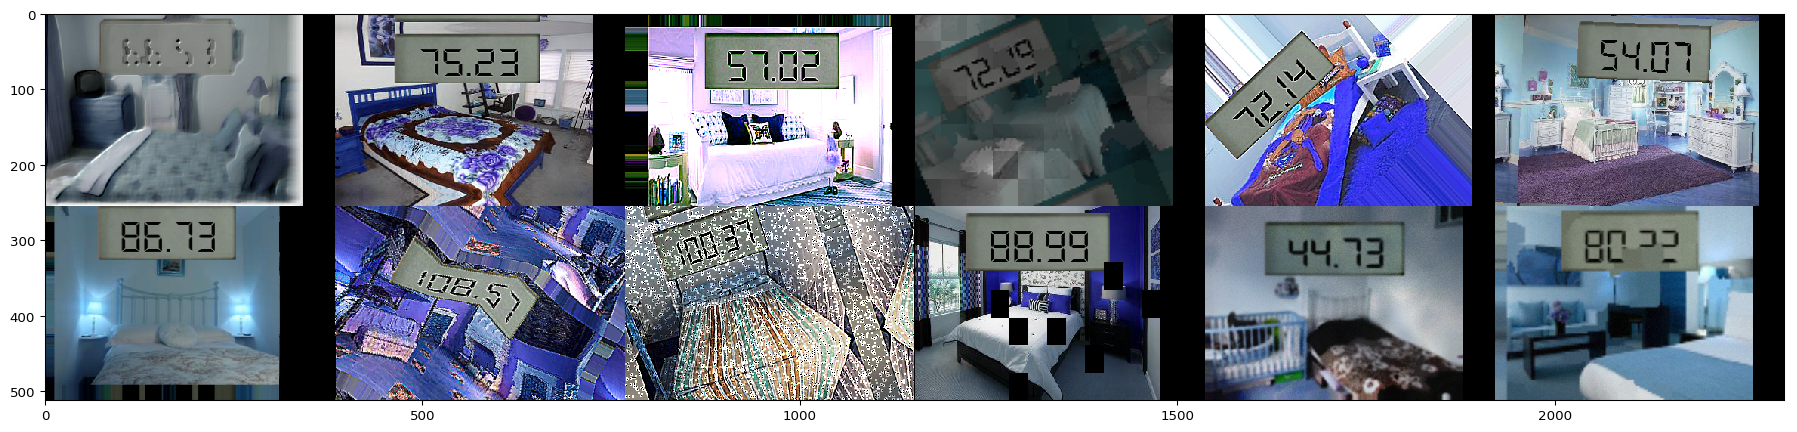

In [0]:
print("Augmented:")
ia.imshow(ia.draw_grid(images_aug, cols=4, rows=2))

In [0]:
#type(images_aug)

list

#8. Converting Numpy to Image Format

In [0]:
#importing a library to convert numpy list to images
!pip install pypng

     |████████████████████████████████| 655kB 5.1MB/s 
  Created wheel for pypng: filename=pypng-0.0.20-cp36-none-any.whl size=67162 sha256=7edf35ea665eb2e16e80a1612a1b63346ec2f4aa4b5b898dfcd09d8857a12816
  Stored in directory: /root/.cache/pip/wheels/41/6b/ef/0493b536b6d4722c2ae9486691b1d49b922b9877922beeabb3
Successfully built pypng


In [0]:
#Importing Libraries
import png
from PIL import Image

In [0]:
#Saving Images
i = 1
for img in images_aug:
  #png.from_array([[255, 0, 0, 255],
                #[0, 255, 255, 0]], 'L').save("synImage"+str(i)+".png")
  im = Image.fromarray(img)
  im.save("synImage"+str(i)+".png")
  i= i+1

In [0]:
#Checking if Images are Created
!ls

gdrive		  synImage1952.png  synImage2904.png  synImage3857.png
sample_data	  synImage1953.png  synImage2905.png  synImage3858.png
synImage1000.png  synImage1954.png  synImage2906.png  synImage3859.png
synImage1001.png  synImage1955.png  synImage2907.png  synImage385.png
synImage1002.png  synImage1956.png  synImage2908.png  synImage3860.png
synImage1003.png  synImage1957.png  synImage2909.png  synImage3861.png
synImage1004.png  synImage1958.png  synImage290.png   synImage3862.png
synImage1005.png  synImage1959.png  synImage2910.png  synImage3863.png
synImage1006.png  synImage195.png   synImage2911.png  synImage3864.png
synImage1007.png  synImage1960.png  synImage2912.png  synImage3865.png
synImage1008.png  synImage1961.png  synImage2913.png  synImage3866.png
synImage1009.png  synImage1962.png  synImage2914.png  synImage3867.png
synImage100.png   synImage1963.png  synImage2915.png  synImage3868.png
synImage1010.png  synImage1964.png  synImage2916.png  synImage3869.png
synImage1011.png  s

#9. Downloading Files on The Local Desktop

In [0]:
from google.colab import files

In [0]:
i = 1
while i != 4228:
  files.download('synImage'+ str(i)+'.png')
  i= i+1